# Imports

In [1]:
# Imports padrão
import os
import warnings
from pathlib import Path
import pandas as pd

# Configurações iniciais
warnings.filterwarnings("ignore", message="Protobuf gencode version")

# Imports locais (funções e constantes definidas no projeto)
from functions import (
    # Carregamento e preparação de dados
    load_datasets, prepare_daily_series, preprocess_price, build_group_map,
    expand_to_full_calendar, aggregate_group_daily, deseasonalize_spent,
    
    # Análise e visualização
    print_average_daily_points, analyze_seasonality, plot_raw_price_by_product,
    plot_window_correlation_by_product, plot_dual_axis,
    
    # Engenharia de features
    compute_base_features, compute_rolling_targets, enrich_history_with_features,

    # Modelagem
    build_mlp, train_mlp_model, run_training_pipeline,
    evaluate_model, predict_mlp, get_history_for_pair, avaliar_todos_modelos,

    # Alocação e previsão
    compute_response_curve, predict_todays_spend,
    recursive_allocation_forecast, allocate_budget_dp, simple_distribute_points,
    expand_group_alloc_to_clients,

    # Constantes
    BASE_PATH, MLFLOW_DIR, OUTPUT_PATH
)

# Exploratory Data Analysis

Iniciamos comparando as séries temporais de vendas (`historical_orders`) com os pontos de marketing (`marketing_points`). Identificamos que a correlação entre essas variáveis se torna mais evidente quando aplicamos médias móveis às séries, o que suaviza flutuações de curto prazo e destaca tendências mais amplas.

No entanto, as séries de vendas apresentam uma sazonalidade anual bastante pronunciada. Para representar de forma mais precisa a relação com os pontos de marketing, esse efeito sazonal foi removido, possibilitando uma análise de correlação mais robusta.

Após a dessazonalização, observamos que os produtos **0** e **1** apresentam correlações significativas com os pontos de marketing, variando entre **0.4 e 0.5**, com aumento consistente à medida que a janela da média móvel cresce. Já o produto **2** mostra uma correlação menor, com um pico por volta de **34 dias de janela**, seguido de uma redução conforme janelas maiores são utilizadas.

Ao analisarmos a evolução dos preços ao longo do tempo, verificamos que **não ocorreram variações substanciais**. Os preços permaneceram relativamente estáveis nos últimos anos, o que reduz a chance de confundirmos efeitos de preço com o impacto dos pontos de marketing.

In [2]:
historical_orders, marketing_points, price = load_datasets()

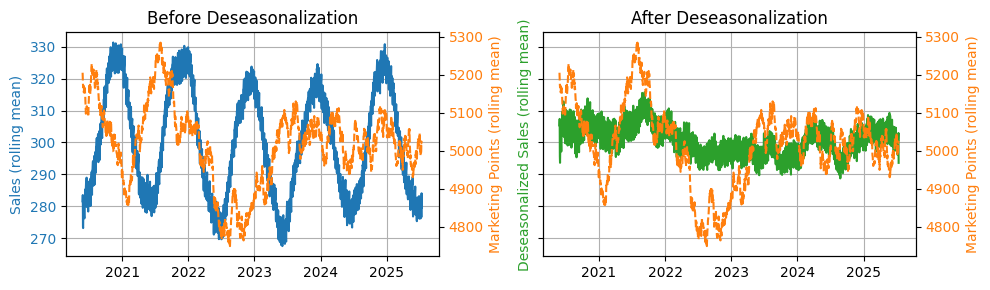

In [3]:
daily_quantity, daily_points = prepare_daily_series(historical_orders, marketing_points, date_col='date',
                                                    quantity_col='quantity', points_col='points')

analyze_seasonality(daily_quantity, daily_points, window=180, period=365)

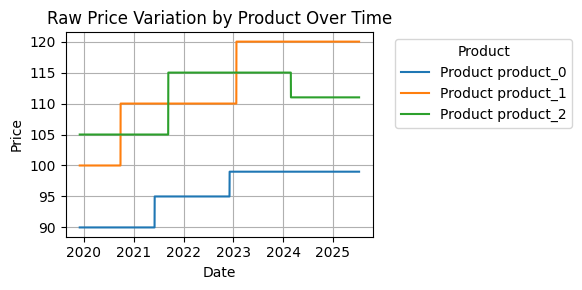

In [4]:
plot_raw_price_by_product(price)

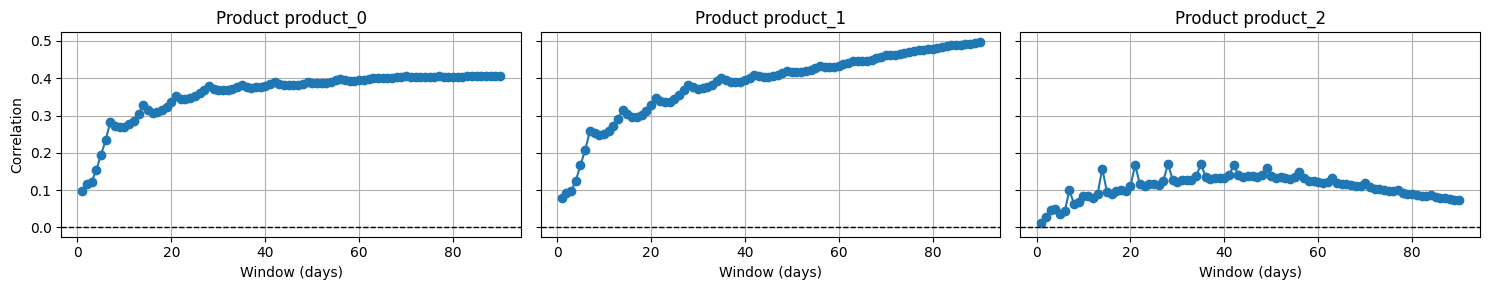

In [5]:
plot_window_correlation_by_product(historical_orders=historical_orders, marketing_points=marketing_points,
                                   seasonality_period=365, min_window=1, max_window=90)

In [6]:
average_daily = print_average_daily_points(marketing_points)
print(f"Average daily marketing points over the period: {average_daily:.2f}")

Average daily marketing points over the period: 5026.73


# Conclusão da análise exploratória e descrição da metodologia

### Modelamento do Comportamento dos Clientes e Alocação Ótima de Pontos

Identificamos que o impacto dos pontos de marketing sobre as vendas varia de acordo com o produto, sendo necessário analisar cada produto separadamente. Assim, optamos por **modelar o comportamento dos clientes com relação aos pontos de marketing recebidos por produto**.

A modelagem individual por cliente, no entanto, é inviável devido à **baixa frequência de registros por cliente**, o que impede o aprendizado adequado de seus padrões de resposta. Para contornar essa limitação, optamos por **agrupar os clientes em quatro grupos**, com base na **relação entre os pontos de marketing recebidos e a quantidade de compras realizadas**. Essa abordagem nos permite **diferenciar clientes mais influenciados pelo marketing daqueles menos sensíveis**, viabilizando um modelamento mais robusto.

Para mapear o comportamento de cada grupo de clientes, utilizamos uma **rede neural do tipo MLP (Multi-Layer Perceptron)**. O modelo é alimentado com **features derivadas das médias móveis das séries de marketing e vendas**, tais como:

- Pontos de marketing alocados no dia atual;
- Médias móveis de pontos de marketing até o dia atual;
- Quantidade de vendas do dia anterior;
- Médias móveis de vendas até o dia anterior.

O objetivo do modelo é **prever a quantidade de vendas do dia atual** e também as **médias móveis das vendas dos próximos dias**, permitindo identificar o impacto imediato e futuro dos pontos de marketing investidos hoje.

Com o comportamento aprendido para cada grupo de clientes, seguimos para a etapa de **otimização da receita**. Nessa fase, testamos diversas combinações possíveis de pontos de marketing entre produtos e grupos, utilizando o modelo treinado para prever as vendas e calcular a receita correspondente. A **combinação que retorna a maior receita** é selecionada.

Após essa alocação ideal entre produtos e grupos, os pontos de marketing são **distribuídos de forma simples entre os clientes dentro de cada grupo**, já que **não há, por ora, padrões mais sofisticados identificáveis para otimização no nível individual**.

A proposta final do modelo é que ele **faça o planejamento da alocação de pontos para o dia atual**, utilizando as informações dos últimos 180 dias. No entanto, o mesmo modelo pode ser **usado de forma recursiva** para simular a evolução futura e **planejar vários dias à frente**, se necessário.

# Preparação dos dados que serão utilizados para modelar o comportamento de resposta ao marketing dos grupos de clientes.

In [7]:
# Carregar os dados
historical_orders, marketing_points, price = load_datasets()

# Garantir que as colunas de data estejam no mesmo formato
historical_orders['date'] = pd.to_datetime(historical_orders['date'])
marketing_points['date'] = pd.to_datetime(marketing_points['date'])
price['date'] = pd.to_datetime(price['date'])

# Define o intervalo total de datas com base nos dados históricos
min_date = min(historical_orders["date"].min(), marketing_points["date"].min(), price["date"].min())
max_date = max(historical_orders["date"].max(), marketing_points["date"].max(), price["date"].max())

# Aplica o pré-processamento da tabela de preços
price = preprocess_price(price, min_date=min_date, max_date=max_date)

# Dessazonalizar o spend (gasto)
historical_orders = (
    historical_orders
    .merge(price, on=['product','date'], how='left')
    .assign(spend=lambda df: df.quantity * df.price)
)
historical_orders = deseasonalize_spent(
    historical_orders,
    product_col="product",
    date_col="date",
    value_col="spend",
    period=365,
    model="additive"
)

In [8]:
# Construir grupos de clientes
group_map = build_group_map(
    orders=historical_orders,
    points=marketing_points,
    n_groups=4
)

# Agregar vendas e pontos por product×group×dia
df_gp = aggregate_group_daily(
    orders=historical_orders,
    points=marketing_points,
    group_map=group_map
)

# Expandir calendário completo
df_full = expand_to_full_calendar(
    df_gp,
    start=historical_orders['date'].min(),
    end=historical_orders['date'].max()
)

# Calcular features base (lags e médias móveis de spent e points)
df_base = compute_base_features(
    df_full,
    windows=[180,90,60,34,28,21,14,7])

# Gerar targets rolling sobre o spend
df_feat = compute_rolling_targets(
    df_base,
    horizon=14,
    window=180)

# Treinando as redes neurais que vão modelar o comportamento dos grupos de clientes em relação ao marketing.

In [9]:
import mlflow

os.makedirs(MLFLOW_DIR, exist_ok=True)


mlflow.set_tracking_uri(MLFLOW_DIR.as_uri())  # Seu path para mlruns convertido em URI

experiment_name = "Desafio_MT2"

# Tenta criar o experimento, se já existir só pega o ID
try:
    experiment_id = mlflow.create_experiment(experiment_name)
except mlflow.exceptions.MlflowException:
    experiment = mlflow.get_experiment_by_name(experiment_name)
    experiment_id = experiment.experiment_id

print(f"Usando experimento: {experiment_name} (ID: {experiment_id})")





df_feat = df_feat.dropna().reset_index(drop=True)


# FEATURE E TARGETS
x_cols = [
    'points',
    'points_ma_7', 'points_ma_14', 'points_ma_21', 'points_ma_28',
    'points_ma_34', 'points_ma_60', 'points_ma_90', 'points_ma_180',
    'spend_ma_7', 'spend_ma_14', 'spend_ma_21', 'spend_ma_28',
    'spend_ma_34', 'spend_ma_60', 'spend_ma_90', 'spend_ma_180',
    'spend_lag1'
]

y_cols = [
    'total_spend', 'target_spend_ma180_tplus0',   'target_spend_ma180_tplus1',
    'target_spend_ma180_tplus2',  'target_spend_ma180_tplus3',   'target_spend_ma180_tplus4',
    'target_spend_ma180_tplus5',  'target_spend_ma180_tplus6',   'target_spend_ma180_tplus7',
    'target_spend_ma180_tplus8',  'target_spend_ma180_tplus9',   'target_spend_ma180_tplus10',
    'target_spend_ma180_tplus11', 'target_spend_ma180_tplus12',  'target_spend_ma180_tplus13'
]

mlp_models = run_training_pipeline(df_feat, x_cols, y_cols, experiment_id)

2025/08/03 17:27:29 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



Usando experimento: Desafio_MT2 (ID: 858763765629880685)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


# Avaliando os modelos

In [10]:
test_df = df_feat[df_feat['date'] >= '2025-01-01']
avaliacoes_df = avaliar_todos_modelos(test_df, mlp_models, x_cols, y_cols)
avaliacoes_df

,product,group_id,r2_mean,r2_total_spend,r2_target_spend_ma180_tplus0,r2_target_spend_ma180_tplus1,r2_target_spend_ma180_tplus2,r2_target_spend_ma180_tplus3,r2_target_spend_ma180_tplus4,r2_target_spend_ma180_tplus5,r2_target_spend_ma180_tplus6,r2_target_spend_ma180_tplus7,r2_target_spend_ma180_tplus8,r2_target_spend_ma180_tplus9,r2_target_spend_ma180_tplus10,r2_target_spend_ma180_tplus11,r2_target_spend_ma180_tplus12,r2_target_spend_ma180_tplus13
0,product_0,G1,0.744815,0.001344,0.809238,0.786625,0.742806,0.778750,0.768354,0.817895,0.814779,0.819166,0.794594,0.804097,0.792878,0.792470,0.820929,0.828296
1,product_0,G2,0.746331,0.023711,0.864293,0.826268,0.787851,0.813354,0.816916,0.825075,0.829267,0.807330,0.789928,0.775033,0.765297,0.742045,0.758897,0.769701
2,product_0,G3,0.829540,0.044332,0.864483,0.829632,0.864635,0.862668,0.891001,0.897150,0.907246,0.900618,0.894983,0.896168,0.890236,0.896802,0.894472,0.908672
3,product_0,G4,0.072973,0.001962,0.353221,0.316585,0.289882,0.276222,0.189323,0.119090,0.086182,0.104706,-0.047742,-0.037123,-0.041009,-0.117976,-0.165504,-0.233227
4,product_1,G1,0.600397,0.030759,0.810425,0.741911,0.766704,0.834198,0.665835,0.741777,0.694580,0.664655,0.635430,0.570185,0.502828,0.522185,0.341372,0.483115
5,product_1,G2,0.321700,-0.004295,0.446179,0.490000,0.445965,0.402060,0.388222,0.328350,0.351247,0.288766,0.354127,0.273719,0.287527,0.235155,0.233629,0.304848
6,product_1,G3,0.449350,-0.005940,0.631732,0.575382,0.588121,0.602958,0.553672,0.528533,0.526723,0.455784,0.460164,0.415411,0.389058,0.391556,0.307172,0.319926
7,product_1,G4,0.369485,0.007106,0.570710,0.616679,0.494697,0.400839,0.452473,0.476148,0.375469,0.445728,0.215942,0.335700,0.357612,0.479745,0.170162,0.143260
8,product_2,G1,0.801649,0.820052,0.858024,0.780353,0.793713,0.793097,0.804836,0.835045,0.864720,0.791866,0.742622,0.759215,0.771667,0.765975,0.798878,0.844674
9,product_2,G2,0.732030,0.666626,0.819186,0.745089,0.756594,0.717233,0.770561,0.802938,0.755353,0.716515,0.676216,0.714763,0.679930,0.716216,0.712052,0.731175


# Otimizando e usando de forma sequencial para fazer múltiplas alocações

In [11]:
extended_df, alloc_schedule = recursive_allocation_forecast(
    df_gp, mlp_models, x_cols, y_cols,
    steps=2, B=5000, lookback=180, step=1000,)

# Alocando os pontos de marketing por cliente de cada grupo

In [12]:
client_alloc_df = expand_group_alloc_to_clients(alloc_schedule, group_map)

In [13]:
# salva no arquivo solution.csv dentro de base_path
client_alloc_df.to_csv(OUTPUT_PATH, index=False)

print(f"Arquivo salvo em {OUTPUT_PATH}")
print(client_alloc_df)

Arquivo salvo em c:\Users\engen\OneDrive\Área de Trabalho\desafio_mt2\solution.csv
         date    product     client  points
0  2025-07-13  product_2   client_6     210
1  2025-07-13  product_2  client_35      10
2  2025-07-13  product_2   client_4     500
3  2025-07-13  product_2  client_76      50
4  2025-07-13  product_2  client_51     200
5  2025-07-13  product_2  client_85     500
6  2025-07-13  product_2  client_10      50
7  2025-07-13  product_2  client_47     100
8  2025-07-13  product_2  client_86     100
9  2025-07-13  product_2   client_0     200
10 2025-07-13  product_2   client_8     300
11 2025-07-13  product_2   client_7     500
12 2025-07-13  product_2  client_22      10
13 2025-07-13  product_2  client_99     500
14 2025-07-13  product_2  client_79     500
15 2025-07-13  product_2  client_26      50
16 2025-07-13  product_2  client_31     300
17 2025-07-13  product_2  client_97     100
18 2025-07-13  product_2  client_71     500
19 2025-07-13  product_2  client_80  